In [36]:
# Import libraries necessary for this project
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [28]:
#import dataset
fundamentals_dataset =  pd.read_csv('./datasets/fundamentals.csv', header=0)
prices_dataset =  pd.read_csv('./datasets/prices-split-adjusted.csv', header=0)
securities_dataset =  pd.read_csv('./datasets/securities.csv', header=0)

## Data Exploration

First, I'll make a cursory investigation about S&P 500 datasets. It'll help me better understand about data and problem.  
I'll use visualization and calculate statistics about dataset.

In [56]:
## check if nan exists
prices_dataset.isnull().values.any()

False

In [62]:
# helper function to plot prices.
def plot_close_prices_by_symbol(symbol, data):
    data_by_symbol = data[data['symbol']==symbol]
    close_prices = data_by_symbol.close.values.astype('float32')
    sns.tsplot(data=close_prices,value=symbol + " stock prices")

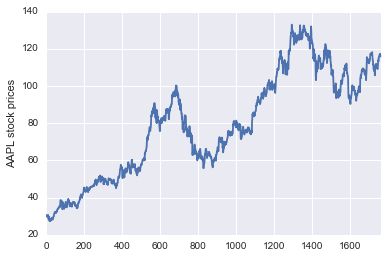

In [63]:
%matplotlib inline
## visualize Apple's stock prices
plot_close_prices_by_symbol('AAPL', prices_dataset)

In [79]:
all_company_prices = prices_dataset['close']
minimum_price = np.min(all_company_prices)
maximum_price = np.max(all_company_prices)
mean_price = np.mean(all_company_prices)
median_price = np.median(all_company_prices)
std_price = np.std(all_company_prices)

# Show the calculated statistics
print "Statistics for S&P 500 datasets:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for S&P 500 datasets:

Minimum price: $1.59
Maximum price: $1,578.13
Mean price: $65.01
Median price $48.48
Standard deviation of prices: $75.20


[422  64   8   1   1   4   0   0   0   1]


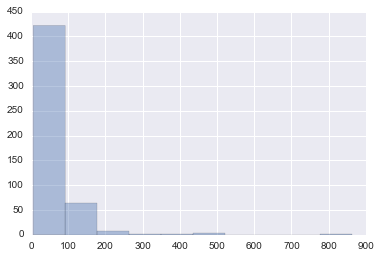

In [122]:
## check if outlier company exists
mean_company_prices = prices_dataset.groupby('symbol')['close'].mean()
sns.distplot(mean_company_prices.values, kde=False, rug=False, bins=10)

hist, bin_edges = np.histogram(mean_company_prices.values, bins=10)
print hist

[  3   4   4   0   6  14   0   0   1 469]
1762


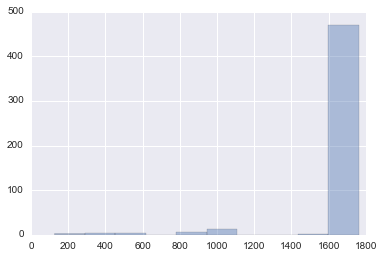

In [175]:
## check if young company exists
company_history = prices_dataset.groupby('symbol')['close'].count()
sns.distplot(company_history.values, kde=False, rug=False, bins=10)

hist, bin_edges = np.histogram(company_history.values, bins=10)
print hist
max_history = company_history.max()
print max_history

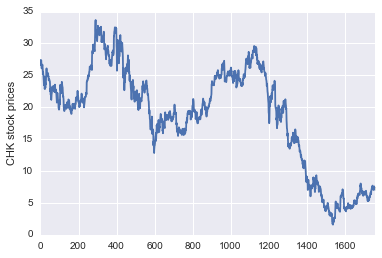

In [64]:
%matplotlib inline
## Visualize prices of company that has min price.
min_company_symbol = prices_dataset[prices_dataset['close']==minimum_price]['symbol'].values[0]
plot_close_prices_by_symbol(min_company_symbol, prices_dataset)

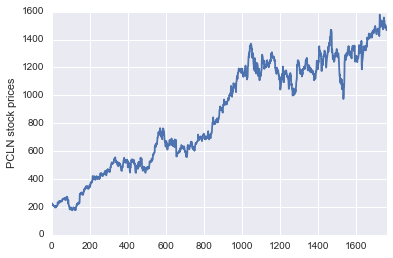

In [65]:
%matplotlib inline
## Visualize prices of company that has min price.
max_company_symbol = prices_dataset[prices_dataset['close']==maximum_price]['symbol'].values[0]
plot_close_prices_by_symbol(max_company_symbol, prices_dataset)

## Preprocessing
Before building models, I have to do data preprocessing.  
Based on the results of Data Exploration, Based on the results of Data Exploration, I determined to exclude outliers and young companies.

In [170]:
## exclude outliers and young company.
excluded_outlier_df = pd.DataFrame({'symbol':mean_company_prices[mean_company_prices < 600].index})
excluded_young_df = pd.DataFrame({'symbol':company_history[company_history == 1762].index})

excluded_outlier_dataset = pd.merge(prices_dataset, excluded_df, on='symbol')
excluded_dataset = pd.merge(excluded_outlier_dataset, excluded_young_df, on='symbol')

all_company_prices = excluded_dataset['close']
minimum_price = np.min(all_company_prices)
maximum_price = np.max(all_company_prices)
mean_price = np.mean(all_company_prices)
median_price = np.median(all_company_prices)
std_price = np.std(all_company_prices)

# Show the calculated statistics
print "Statistics for S&P 500 datasets:\n"
print "Number of company: {:,d}".format(excluded_dataset.groupby('symbol')['close'].apply(list).count())
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for S&P 500 datasets:

Number of company: 466
Minimum price: $1.59
Maximum price: $844.36
Mean price: $63.54
Median price $48.49
Standard deviation of prices: $63.98


## Build benchmark models

In [143]:
## function to create training dataset.
def create_dataset(dataset, time_steps= 1):  
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i : (i + time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [182]:
# create training and testing dataset.
train_ratio = 0.7
train_size = int(max_history * train_ratio)
test_size = max_history - train_size

company_prices = excluded_dataset.groupby('symbol')['close'].apply(list)
company_prices_train = company_prices.apply(lambda x : x[0:train_size])
company_prices_test = company_prices.apply(lambda x : x[train_size:max_history])

In [184]:
# use 50 timesteps to predict next 1 time step.
use_time_steps = 50
predict_time_steps = 1

In [236]:
# helper function to build benchmark models.
def calc_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

def get_prediction_result(row, pred_func, time_steps):
    x, y = create_dataset(row, time_steps)
    predicted = pred_func(x)
    return np.array([y, predicted])

In [237]:
# Benchmark1 : the model outputs the historical mean value.
predict_benchmark1 = lambda x : np.mean(x, axis = 1)
benchmark1_res = company_prices_test.apply(lambda x : get_prediction_result(x, predict_benchmark1, use_time_steps))
benchmark1_rmse = benchmark1_res.apply(lambda x : calc_rmse(x[0, :], x[1, :]))
benchmark1_total_rmse = np.mean(benchmark1_rmse)
print "RMSE of Benchmark 1: {:,.4f}".format(benchmark1_total_rmse)

RMSE of Benchmark 1: 4.9982


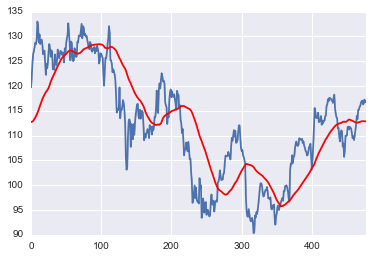

In [243]:
# visualize output of benchmark model 1.
sns.tsplot(data=benchmark1_res['AAPL'][0, :])
sns.tsplot(data=benchmark1_res['AAPL'][1, :], color="r")

In [244]:
# Benchmark2 : the model outputs the very last observation out.
predict_benchmark2 = lambda x : x[:, -1]
benchmark2_res = company_prices_test.apply(lambda x : get_prediction_result(x, predict_benchmark2, use_time_steps))
benchmark2_rmse = benchmark2_res.apply(lambda x : calc_rmse(x[0, :], x[1, :]))
benchmark2_total_rmse = np.mean(benchmark2_rmse)
print "RMSE of Benchmark 2: {:,.4f}".format(np.mean(benchmark2_total_rmse))

RMSE of Benchmark 2: 1.3151


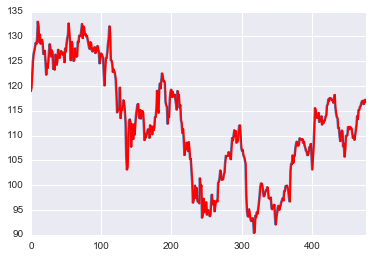

In [245]:
# visualize output of benchmark model 2.
sns.tsplot(data=benchmark2_res['AAPL'][0, :])
sns.tsplot(data=benchmark2_res['AAPL'][1, :], color="r")

In [ ]:
# Benchmark2 : the model outputs the very last observation out.
